## Analyze Sweep Results

Import libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Top 5 Multitask Runs

In [33]:
# Load CSV file
df = pd.read_csv("logs/multitask_backup.csv")
# Keep only rows with all necessary metrics
valid_df = df.dropna(subset=["val_dice", "val_auc", "val_loss"]).copy()
# Compute composite multitask score
valid_df["score"] = valid_df["val_dice"] + valid_df["val_auc"] - valid_df["val_loss"]
# Sort by score and select top 5
top_5 = valid_df.sort_values(by="score", ascending=False).head(5)
# Select and display relevant columns
columns_to_display = [
    "Name", "val_dice", "val_iou", "val_auc", "val_loss", "score", "batch_size", "alpha", "beta", "dropout", "l2_reg"
]
top_5_summary = top_5[columns_to_display].reset_index(drop=True)
# Display result
print(top_5_summary)

                  Name  val_dice   val_iou   val_auc  val_loss     score  \
0       worthy-sweep-7  0.662345  0.564813  0.680612  0.879587  0.463371   
1    dauntless-sweep-5  0.661324  0.562992  0.686600  0.892120  0.455804   
2        sage-sweep-11  0.660541  0.563394  0.697290  0.912254  0.445577   
3         rare-sweep-6  0.662471  0.564683  0.677408  0.904681  0.435198   
4  distinctive-sweep-9  0.662754  0.565401  0.663213  0.891096  0.434871   

   batch_size  alpha  beta   dropout    l2_reg  
0          16    2.0   0.5  0.202229  0.000079  
1          32    2.0   1.0  0.209321  0.000063  
2          16    1.0   0.5  0.190640  0.000124  
3          32    2.0   1.0  0.186945  0.000094  
4          16    2.0   0.5  0.178475  0.000101  


In [34]:
import pandas as pd

df = pd.read_csv("logs/multitask_backup.csv")
top_5 = (
    df.dropna(subset=["val_dice", "val_auc", "val_loss"])
      .assign(score=lambda x: x["val_dice"] + x["val_auc"] - x["val_loss"])
      .sort_values("score", ascending=False)
      .head(5)
      .reset_index(drop=True)
)

print(top_5[[
    "Name", "val_dice", "val_iou", "val_auc", "val_loss", "score",
    "batch_size", "alpha", "beta", "dropout", "l2_reg"
]])

                  Name  val_dice   val_iou   val_auc  val_loss     score  \
0       worthy-sweep-7  0.662345  0.564813  0.680612  0.879587  0.463371   
1    dauntless-sweep-5  0.661324  0.562992  0.686600  0.892120  0.455804   
2        sage-sweep-11  0.660541  0.563394  0.697290  0.912254  0.445577   
3         rare-sweep-6  0.662471  0.564683  0.677408  0.904681  0.435198   
4  distinctive-sweep-9  0.662754  0.565401  0.663213  0.891096  0.434871   

   batch_size  alpha  beta   dropout    l2_reg  
0          16    2.0   0.5  0.202229  0.000079  
1          32    2.0   1.0  0.209321  0.000063  
2          16    1.0   0.5  0.190640  0.000124  
3          32    2.0   1.0  0.186945  0.000094  
4          16    2.0   0.5  0.178475  0.000101  


Visualize All Runs

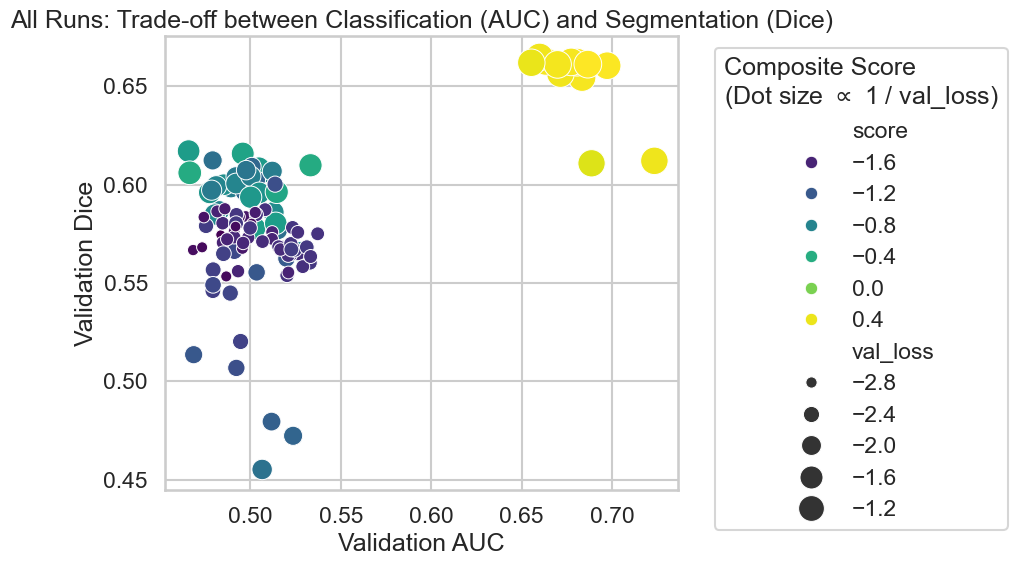

In [20]:
# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=valid_df,
    x="val_auc",
    y="val_dice",
    size=-valid_df["val_loss"],         # Inverse of loss (larger = better)
    hue="score",                        # Color by score
    palette="viridis",
    sizes=(50, 400),
    legend="brief",                     # Compact legend
    marker="o"                          # Use dot
)

# Axis labels and title
plt.title("All Runs: Trade-off between Classification (AUC) and Segmentation (Dice)")
plt.xlabel("Validation AUC")
plt.ylabel("Validation Dice")

# Update legend title only (combine info)
scatter.legend(
    # title="Composite Score\n(Dot size \u221D 1 / val_loss)",
    title=f"Composite Score\n(Dot size $\propto$ 1 / val_loss)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

# Finalize
plt.grid(True)
plt.tight_layout()
plt.show()


Identify Top-Right Cluster

In [22]:
dice_threshold_top = valid_df["val_dice"].quantile(0.85)
auc_threshold_top = valid_df["val_auc"].quantile(0.85)

top_right_cluster = valid_df[
    (valid_df["val_dice"] >= dice_threshold_top) &
    (valid_df["val_auc"] >= auc_threshold_top)
].sort_values(by="score", ascending=False)

 Identify Left-Side Cluster

In [23]:
auc_threshold_left = valid_df["val_auc"].quantile(0.25)
dice_threshold_mid = valid_df["val_dice"].quantile(0.5)

left_cluster = valid_df[
    (valid_df["val_auc"] <= auc_threshold_left) &
    (valid_df["val_dice"] >= dice_threshold_mid)
]

Label Clusters for Comparison

In [14]:
def classify_cluster(row):
    if row["val_dice"] >= dice_threshold_top and row["val_auc"] >= auc_threshold_top:
        return "Top-Right (High Dice & AUC)"
    elif row["val_auc"] <= auc_threshold_left and row["val_dice"] >= dice_threshold_mid:
        return "Left (Low AUC, Mid Dice)"
    else:
        return "Other"

valid_df["Cluster"] = valid_df.apply(classify_cluster, axis=1)

In [24]:
top_right_cluster = top_right_cluster.copy()
left_cluster = left_cluster.copy()

top_right_cluster["Cluster"] = "Top-Right (High Dice & AUC)"
left_cluster["Cluster"] = "Left (Low AUC, Mid Dice)"

# Combine
compare_df = pd.concat([top_right_cluster, left_cluster], ignore_index=True)

Compare Hyperparameter Distributions

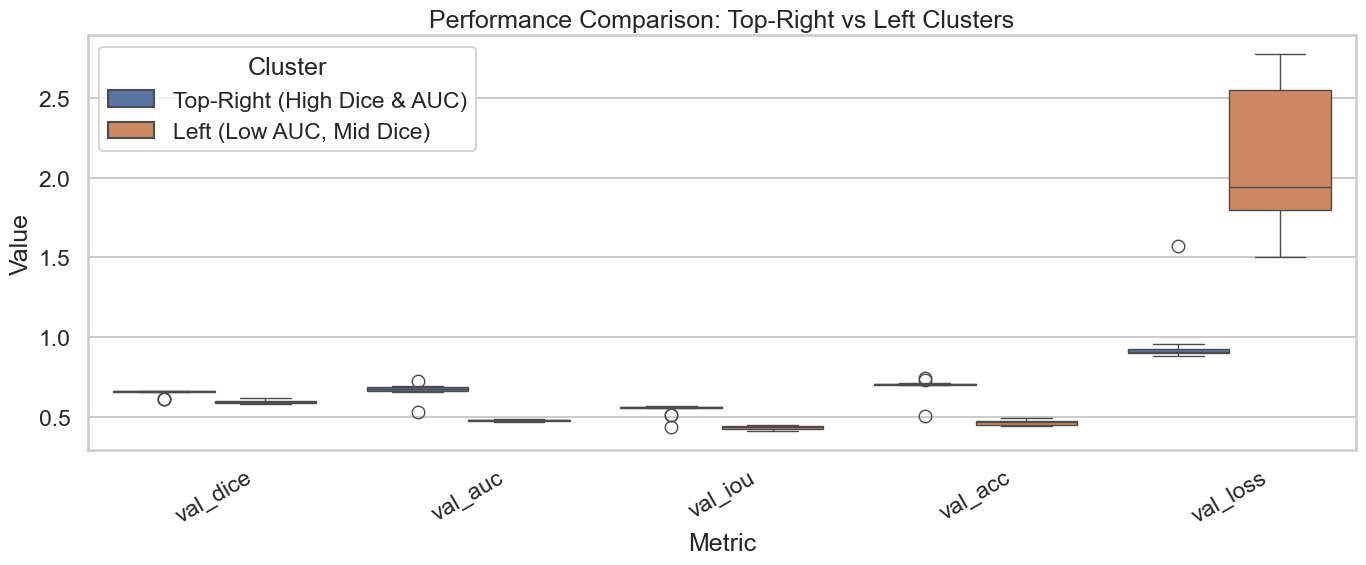

In [26]:
performance_metrics = ["val_dice", "val_auc", "val_iou", "val_acc", "val_loss"]

melted_perf = compare_df.melt(
    id_vars="Cluster",
    value_vars=performance_metrics,
    var_name="Metric",
    value_name="Value"
)

plt.figure(figsize=(14, 6))
sns.boxplot(data=melted_perf, x="Metric", y="Value", hue="Cluster")
plt.title("Performance Comparison: Top-Right vs Left Clusters")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [28]:
# Select hyperparameters to analyze
hyperparams = ["alpha", "beta", "dropout", "l2_reg", "batch_size", "lr_multiplier"]
# Compute descriptive statistics from top-right cluster
refined_ranges = top_right_cluster[hyperparams].agg(["min", "max", "mean", "std"]).T
# Round for readability
refined_ranges = refined_ranges.round(6)
# Optional: sort by parameter name
refined_ranges = refined_ranges.sort_index()
print(refined_ranges)

                     min         max       mean        std
alpha           0.500000    2.000000   1.576923   0.571772
batch_size     16.000000  128.000000  38.153846  40.550064
beta            0.500000    2.000000   0.961538   0.518875
dropout         0.178029    0.239493   0.200688   0.017743
l2_reg          0.000025    0.000130   0.000086   0.000028
lr_multiplier   0.845393    1.135939   1.009865   0.096005


Refined Sweep YAML

```yaml
method: bayes
metric:
  name: val_auc
  goal: maximize

parameters:
  alpha:
    min: 1.8
    max: 2.0
  beta:
    min: 0.5
    max: 1.0
  dropout:
    min: 0.18
    max: 0.21
  l2_reg:
    min: 6e-5
    max: 1.2e-4
  batch_size:
    values: [16, 32]
  lr_multiplier:
    min: 0.9
    max: 1.2
  base_learning_rate:
    value: 0.0002
```

```yaml
  alpha:
    distribution: normal
    mu: 1.58
    sigma: 0.57
  beta:
    distribution: normal
    mu: 0.96
    sigma: 0.52

Scatter plot

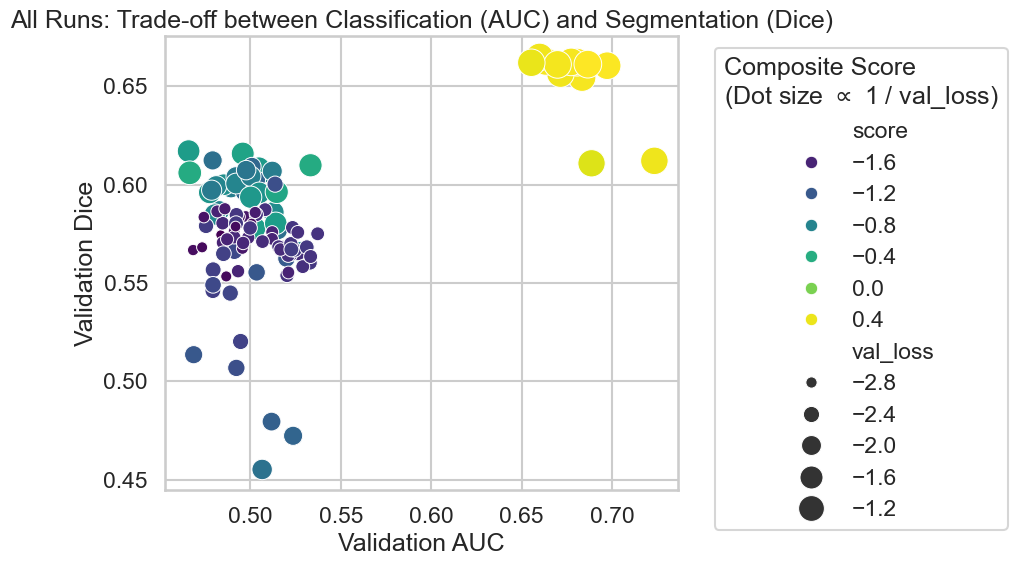

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load sweep results CSV
df = pd.read_csv("logs/multitask_backup.csv")

# Filter valid runs
valid_df = df.dropna(subset=["val_dice", "val_auc", "val_loss"]).copy()

# Compute composite score
valid_df["score"] = valid_df["val_dice"] + valid_df["val_auc"] - valid_df["val_loss"]

# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=valid_df,
    x="val_auc",
    y="val_dice",
    size=-valid_df["val_loss"],         # Inverse of loss (larger = better)
    hue="score",                        # Color by score
    palette="viridis",
    sizes=(50, 400),
    legend="brief",                     # Compact legend
    marker="o"                          # Use dot
)

# Axis labels and title
plt.title("All Runs: Trade-off between Classification (AUC) and Segmentation (Dice)")
plt.xlabel("Validation AUC")
plt.ylabel("Validation Dice")

# Update legend title only (combine info)
scatter.legend(
    # title="Composite Score\n(Dot size \u221D 1 / val_loss)",
    title=f"Composite Score\n(Dot size $\propto$ 1 / val_loss)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

# Finalize
plt.grid(True)
plt.tight_layout()
plt.show()
